In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from bcb import sgs

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
TAXAS_URL = 'https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv'

taxas = pd.read_csv(TAXAS_URL, sep=';', decimal=',')
taxas_ipca = taxas.loc[taxas['Tipo Titulo'] == 'Tesouro IPCA+', taxas.columns[:4]]

taxas_ipca

,Tipo Titulo,Data Vencimento,Data Base,Taxa Compra Manha
36,Tesouro IPCA+,15/08/2024,02/10/2007,6.32
37,Tesouro IPCA+,15/05/2015,02/10/2007,6.73
74,Tesouro IPCA+,15/08/2024,01/10/2007,6.35
75,Tesouro IPCA+,15/05/2015,01/10/2007,6.75
108,Tesouro IPCA+,15/08/2024,20/09/2007,6.35
...,...,...,...,...
148793,Tesouro IPCA+,15/08/2024,28/06/2007,5.97
148828,Tesouro IPCA+,15/05/2015,27/06/2007,6.41
148829,Tesouro IPCA+,15/08/2024,27/06/2007,6.01
148864,Tesouro IPCA+,15/08/2024,26/06/2007,5.97


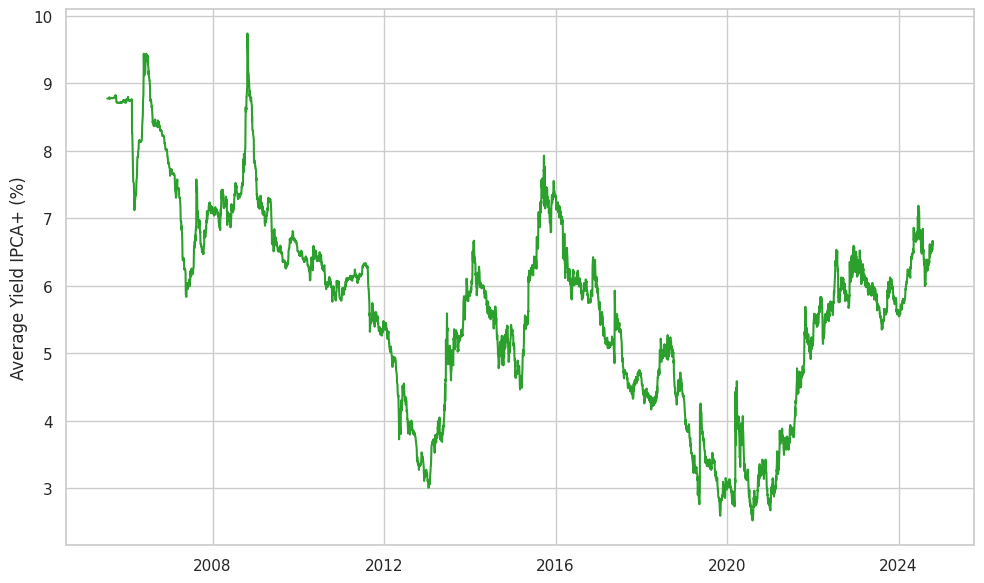

In [4]:
taxas_ipca['Data Base'] =  pd.to_datetime(taxas_ipca['Data Base'], dayfirst=True)
taxas_ipca_diario = taxas_ipca.groupby(['Data Base'])['Taxa Compra Manha'].mean()

plt.figure(figsize=(10, 6))

sns.lineplot(data=taxas_ipca_diario, color='tab:green')

plt.ylabel('Average Yield IPCA+ (%)', fontsize=12)
plt.xlabel('', fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
ibov_prices = yf.Ticker('^BVSP').history(start=taxas_ipca_diario.index[0])['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

serie_historica = pd.merge(ibov_prices, taxas_ipca_diario, left_index=True, right_index=True, how='left')
serie_historica['Taxa Compra Manha'] = serie_historica['Taxa Compra Manha'].ffill()

serie_historica

,Close,Taxa Compra Manha
2005-07-18,25321.000000,8.775
2005-07-19,25271.000000,8.775
2005-07-20,25705.000000,8.775
2005-07-21,25842.000000,8.775
2005-07-22,25391.000000,8.775
...,...,...
2024-10-15,131043.000000,6.535
2024-10-16,131750.000000,6.590
2024-10-17,130793.000000,6.665
2024-10-18,130499.000000,6.600


In [6]:
ipca_mensal = sgs.get({'IPCA': 433}, start=taxas_ipca_diario.index[0]).squeeze()

ipca_mensal

Date
2005-07-01    0.25
2005-08-01    0.17
2005-09-01    0.35
2005-10-01    0.75
2005-11-01    0.55
              ... 
2024-05-01    0.46
2024-06-01    0.21
2024-07-01    0.38
2024-08-01   -0.02
2024-09-01    0.44
Name: IPCA, Length: 231, dtype: float64

In [7]:
for month_start in ipca_mensal.index:
    month_end = month_start + pd.offsets.MonthEnd(1)
    tradings_days = serie_historica.loc[month_start:month_end].index
    
    daily_ipca = ipca_mensal.loc[month_start] / len(tradings_days)
    
    serie_historica.loc[tradings_days, 'IPCA Diario'] = daily_ipca

serie_historica = serie_historica.dropna()
serie_historica = serie_historica.set_axis(['IBOV', 'Taxa IPCA+', 'IPCA Diario'], axis=1)

serie_historica

,IBOV,Taxa IPCA+,IPCA Diario
2005-07-18,25321.0,8.7750,0.025000
2005-07-19,25271.0,8.7750,0.025000
2005-07-20,25705.0,8.7750,0.025000
2005-07-21,25842.0,8.7750,0.025000
2005-07-22,25391.0,8.7750,0.025000
...,...,...,...
2024-09-24,132156.0,6.4650,0.020952
2024-09-25,131586.0,6.4225,0.020952
2024-09-26,133010.0,6.4750,0.020952
2024-09-27,132730.0,6.5350,0.020952


In [8]:
window_size = 252

rolling_returns = []
rolling_condition_returns = []

for i in range(window_size, len(serie_historica) + 1):
    window = serie_historica.iloc[i - window_size:i]

    if window.iloc[0, 1] >= 6.5:
        ibov_condition_return = (window['IBOV'].iloc[-1] / window['IBOV'].iloc[0]) - 1
        rolling_condition_returns.append(ibov_condition_return)
    else:
        ibov_return = (window['IBOV'].iloc[-1] / window['IBOV'].iloc[0]) - 1
        rolling_returns.append(ibov_return)
    
print(np.mean(rolling_returns))
print(np.mean(rolling_condition_returns))

0.05178265464700241
0.2450936466077817


In [9]:
def get_ipca_return(data: pd.Series, taxa_fixa: float) -> float:
    ipca_acumulado = (1 + data / 100) * (1 + taxa_fixa)

    retorno_acumulado = ipca_acumulado.cumprod()
    retorno_total = (retorno_acumulado.iloc[-1] / retorno_acumulado.iloc[0]) - 1

    return retorno_total

In [10]:
sizes = {
    '6M': 126,
    '12M': 252,
    '24M': 504,
    '36M': 756,
    '48M': 1008,
}

taxa_diaria_fixa = (1 + 0.065)**(1 / 252) - 1

avg_return = []

for label, window_size in sizes.items():
    returns = []

    for i in range(window_size, len(serie_historica) + 1):
        window = serie_historica.iloc[i - window_size:i]
        
        if window.iloc[0, 1] >= 6.5:
            ibov_return = (window['IBOV'].iloc[-1] / window['IBOV'].iloc[0]) - 1
            ipca_return = get_ipca_return(window['IPCA Diario'], taxa_fixa=taxa_diaria_fixa)

            returns.append({'IBOV': ibov_return, 'IPCA+6%': ipca_return})

    ibov_mean = np.mean([d['IBOV'] for d in returns if 'IBOV' in d])
    ipca_mean = np.mean([d['IPCA+6%'] for d in returns if 'IPCA+6%' in d])

    avg_return.append({'Window': label, 'IBOV': ibov_mean, 'IPCA+6%': ipca_mean})

avg_return = pd.DataFrame(avg_return)

avg_return

,Window,IBOV,IPCA+6%
0,6M,0.122492,0.059529
1,12M,0.245094,0.118551
2,24M,0.399245,0.252784
3,36M,0.386740,0.408299
4,48M,0.530338,0.581127


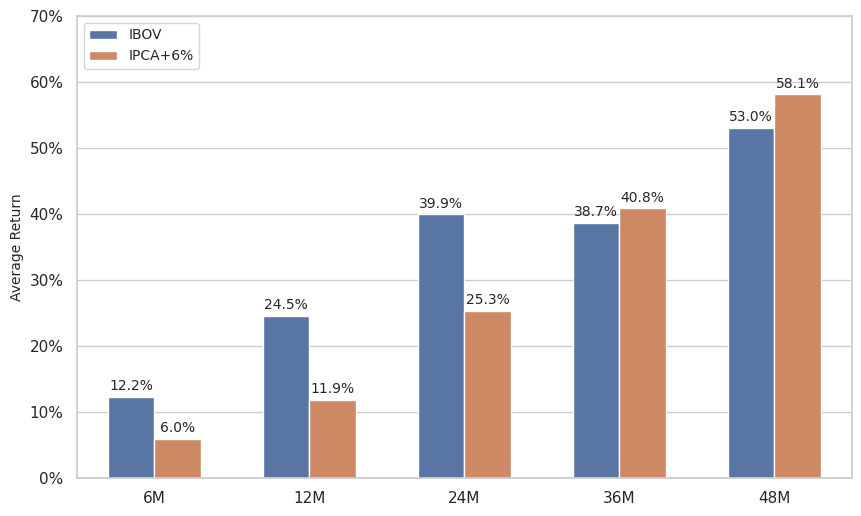

In [11]:
data = pd.melt(avg_return, id_vars='Window', var_name='Investment', value_name='Average Return')

plt.figure(figsize=(10, 6))

g = sns.barplot(
    data, 
    x='Window', 
    y='Average Return',
    hue='Investment',
    width=0.6
)

for p in g.patches:
    height = p.get_height()
    if height != 0:
        g.annotate(
            f'{height:.1%}', 
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            fontsize=10,
            xytext=(0, 5),
            textcoords='offset points'
        )


g.set(yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
g.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])

plt.xlabel('')
plt.ylabel('Average Return', fontsize=10)
plt.legend(title='', loc='upper left', fontsize=10)

plt.show()